## Software Comparison 2 with NIDM-Results

This notebook demonstates how to reproduce the results presented in the second Software Comparison publication using NIDM-Results packs available at [NeuroVault (7113)](http://neurovault.org/collections/7113/). We give visual comparisons between axial slices of the excursion set images and T-statistics for each software packages, as well as quantitative comparisons with Euler characteristics, Bland-Altman plots and Dice coefficients.


In [1]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 7113
 - Download and save the packs in sub-folder `input/ds109/` 

In [2]:
from lib import download_data
reload(download_data)
download_data.download_data('7113', 'ds109', 'ds109')

downloading https://neurovault.org/collections/7113/group.gfeat.nidm.zip at ./input/ds109/group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7113/spm_0001.nidm.zip at ./input/ds109/spm_0001.nidm.zip
downloading https://neurovault.org/collections/7113/spm_0002.nidm.zip at ./input/ds109/spm_0002.nidm.zip
downloading https://neurovault.org/collections/7113/afni_design_group.gfeat.nidm.zip at ./input/ds109/afni_design_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7113/spm_design_group.gfeat.nidm.zip at ./input/ds109/spm_design_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7113/afni_drift_group.gfeat.nidm.zip at ./input/ds109/afni_drift_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7113/spm_drift_group.gfeat.nidm.zip at ./input/ds109/spm_drift_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7113/afni_subject_group.gfeat.nidm.zip at ./input/ds109/afni_subject_group.gfeat.nidm.zip
downloadin

In [3]:
study = 'ds109'
num_subjects = 21

# *** SPM group activations
spm_pack = open('./input/' + study + '/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file = './input/' + study + '/spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/' + study + '/spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/' + study + '/spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_exc_set_file_neg = './input/' + study + '/spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_exc_set_file = './input/' + study + '/fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/' + study + '/fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/' + study + '/fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/' + study + '/fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_mask_file)

# *** AFNI group activations and deactivations
afni_mask_file = './input/' + study + '/afni_mask.nii.gz'
afni_exc_set_file = './input/' + study + '/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/' + study + '/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/' + study + '/afni_stat.nii.gz'

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

# *** Euler Characteristics and Cluster Count
afni_euler_chars = pd.read_csv('./input/' + study + '/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/' + study + '/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/' + study + '/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_cluster_count = pd.read_csv('./input/' + study + '/afni_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_cluster_count = pd.read_csv('./input/' + study + '/fsl_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_cluster_count = pd.read_csv('./input/' + study + '/spm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars, afni_cluster_count, fsl_cluster_count, spm_cluster_count], axis=1)

# *** Permutation Test images
afni_perm = './input/' + study + '/afni_perm.nii.gz'
afni_perm_z = './input/' + study + '/afni_perm_z.nii.gz'
afni_perm_pos_exc = './input/' + study + '/afni_perm_exc_set_pos.nii.gz'
fsl_perm = './input/' + study + '/fsl_perm.nii.gz'
fsl_perm_pos_exc = './input/' + study + '/fsl_perm_exc_set_pos.nii.gz'
fsl_perm_neg_exc = './input/' + study + '/fsl_perm_exc_set_neg.nii.gz'
spm_perm = './input/' + study + '/spm_perm.nii.gz'
spm_perm_pos_exc = './input/' + study + '/spm_perm_exc_set_pos.nii.gz'

perm_exc_sets = dict()
perm_exc_sets["spm permutation"] = (spm_mask_file, spm_perm_pos_exc, spm_perm)
perm_exc_sets["fsl permutation"] = (fsl_mask_file, (fsl_perm_pos_exc, fsl_perm_neg_exc), fsl_perm)
perm_exc_sets["afni permutation"] = (afni_mask_file, afni_perm_pos_exc, afni_perm)

# *** Permutation Test Euler Characteristics and Cluster Count
afni_perm_euler_chars = pd.read_csv('./input/' + study + '/afni_perm_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_perm_euler_chars = pd.read_csv('./input/' + study + '/fsl_perm_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_perm_euler_chars = pd.read_csv('./input/' + study + '/spm_perm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
afni_perm_cluster_count = pd.read_csv('./input/' + study + '/afni_perm_cluster_count.csv', usecols=[1], names=['AFNI Cluster Count'])
fsl_perm_cluster_count = pd.read_csv('./input/' + study + '/fsl_perm_cluster_count.csv', usecols=[1], names=['FSL Cluster Count'])
spm_perm_cluster_count = pd.read_csv('./input/' + study + '/spm_perm_cluster_count.csv', usecols=[1], names=['SPM Cluster Count'])
perm_euler_chars = pd.concat([afni_perm_euler_chars, fsl_perm_euler_chars, spm_perm_euler_chars, afni_perm_cluster_count, fsl_perm_cluster_count, spm_perm_cluster_count], axis=1)

# *** BOLD images
#afni_bold = './input/' + study + '/afni_bold.nii.gz'
#fsl_bold = './input/' + study + '/fsl_bold.nii.gz'
#spm_bold = './input/' + study + '/spm_bold.nii.gz'

# *** AFNI DESIGN IN FSL group activations and deactivations
afni_design_pack = open('./input/' + study + '/afni_design_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(afni_design_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
afni_design_exc_set_file = './input/' + study + '/afni_design_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', afni_design_exc_set_file)
afni_design_exc_set_file_neg = './input/' + study + '/afni_design_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', afni_design_exc_set_file_neg)

# Unthresholded statistics
afni_design_stat_file = './input/' + study + '/afni_design_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', afni_design_stat_file)

# Analysis mask
afni_design_mask_file = './input/' + study + '/afni_design_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', afni_design_mask_file)

# *** SPM DESIGN IN FSL group activations and deactivations
spm_design_pack = open('./input/' + study + '/spm_design_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_design_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_design_exc_set_file = './input/' + study + '/spm_design_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', spm_design_exc_set_file)
spm_design_exc_set_file_neg = './input/' + study + '/spm_design_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', spm_design_exc_set_file_neg)

# Unthresholded statistics
spm_design_stat_file = './input/' + study + '/spm_design_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', spm_design_stat_file)

# Analysis mask
spm_design_mask_file = './input/' + study + '/spm_design_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_design_mask_file)

# *** Permutation Test images from AFNI/SPM design in FSL
afni_design_perm = './input/' + study + '/afni_design_perm.nii.gz'
afni_design_perm_pos_exc = './input/' + study + '/afni_design_perm_exc_set_pos.nii.gz'
afni_design_perm_neg_exc = './input/' + study + '/afni_design_perm_exc_set_neg.nii.gz'

spm_design_perm = './input/' + study + '/spm_design_perm.nii.gz'
spm_design_perm_pos_exc = './input/' + study + '/spm_design_perm_exc_set_pos.nii.gz'
spm_design_perm_neg_exc = './input/' + study + '/spm_design_perm_exc_set_neg.nii.gz'

# *** AFNI DRIFT IN FSL group activations and deactivations
afni_drift_pack = open('./input/' + study + '/afni_drift_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(afni_drift_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
afni_drift_exc_set_file = './input/' + study + '/afni_drift_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', afni_drift_exc_set_file)
afni_drift_exc_set_file_neg = './input/' + study + '/afni_drift_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', afni_drift_exc_set_file_neg)

# Unthresholded statistics
afni_drift_stat_file = './input/' + study + '/afni_drift_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', afni_drift_stat_file)

# Analysis mask
afni_drift_mask_file = './input/' + study + '/afni_drift_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', afni_drift_mask_file)

# *** SPM DRIFT IN FSL group activations and deactivations
spm_drift_pack = open('./input/' + study + '/spm_drift_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_drift_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
spm_drift_exc_set_file = './input/' + study + '/spm_drift_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', spm_drift_exc_set_file)
spm_drift_exc_set_file_neg = './input/' + study + '/spm_drift_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', spm_drift_exc_set_file_neg)

# Unthresholded statistics
spm_drift_stat_file = './input/' + study + '/spm_drift_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', spm_drift_stat_file)

# Analysis mask
spm_drift_mask_file = './input/' + study + '/spm_drift_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', spm_drift_mask_file)

# *** Permutation Test images from AFNI/SPM drift in FSL
afni_drift_perm = './input/' + study + '/afni_drift_perm.nii.gz'
afni_drift_perm_pos_exc = './input/' + study + '/afni_drift_perm_exc_set_pos.nii.gz'
afni_drift_perm_neg_exc = './input/' + study + '/afni_drift_perm_exc_set_neg.nii.gz'

spm_drift_perm = './input/' + study + '/spm_drift_perm.nii.gz'
spm_drift_perm_pos_exc = './input/' + study + '/spm_drift_perm_exc_set_pos.nii.gz'
spm_drift_perm_neg_exc = './input/' + study + '/spm_drift_perm_exc_set_neg.nii.gz'

# *** SPM SUBJECT-LEVEL IN FSL group activations and deactivations
fsl_spm_subject_level_pack = open('./input/' + study + '/spm_subject_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_spm_subject_level_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_spm_subject_level_exc_set_file = './input/' + study + '/fsl_spm_subject_level_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_spm_subject_level_exc_set_file)
fsl_spm_subject_level_exc_set_file_neg = './input/' + study + '/fsl_spm_subject_level_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_spm_subject_level_exc_set_file_neg)

# Unthresholded statistics
fsl_spm_subject_level_stat_file = './input/' + study + '/fsl_spm_subject_level_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_spm_subject_level_stat_file)

# Analysis mask
fsl_spm_subject_level_mask_file = './input/' + study + '/fsl_spm_subject_level_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_spm_subject_level_mask_file)

# *** Permutation Test images from SPM subject-level in FSL
fsl_spm_subject_level_perm = './input/' + study + '/fsl_spm_subject_level_perm.nii.gz'
fsl_spm_subject_level_perm_pos_exc = './input/' + study + '/fsl_spm_subject_level_perm_exc_set_pos.nii.gz'
fsl_spm_subject_level_perm_neg_exc = './input/' + study + '/fsl_spm_subject_level_perm_exc_set_neg.nii.gz'

# *** AFNI SUBJECT-LEVEL IN FSL group activations and deactivations
fsl_afni_subject_level_pack = open('./input/' + study + '/afni_subject_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_afni_subject_level_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
fsl_afni_subject_level_exc_set_file = './input/' + study + '/fsl_afni_subject_level_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', fsl_afni_subject_level_exc_set_file)
fsl_afni_subject_level_exc_set_file_neg = './input/' + study + '/fsl_afni_subject_level_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', fsl_afni_subject_level_exc_set_file_neg)

# Unthresholded statistics
fsl_afni_subject_level_stat_file = './input/' + study + '/fsl_afni_subject_level_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', fsl_afni_subject_level_stat_file)

# Analysis mask
fsl_afni_subject_level_mask_file = './input/' + study + '/fsl_afni_subject_level_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', fsl_afni_subject_level_mask_file)

# *** Permutation Test images from SPM subject-level in FSL
fsl_afni_subject_level_perm = './input/' + study + '/fsl_afni_subject_level_perm.nii.gz'
fsl_afni_subject_level_perm_pos_exc = './input/' + study + '/fsl_afni_subject_level_perm_exc_set_pos.nii.gz'
fsl_afni_subject_level_perm_neg_exc = './input/' + study + '/fsl_afni_subject_level_perm_exc_set_neg.nii.gz'

- Downloading this study's results from the 'Exploring the impact of analysis software on task fMRI results' manuscript 
- Query NeuroVault's API to retreive all NIDM packs in collection 7782
- Download and save the packs in sub-folder `input/ds109/` 

In [4]:
from lib import download_old_data
reload(download_old_data)
download_old_data.download_old_data('7782', 'ds109', 'ds109')

downloading https://neurovault.org/collections/7782/group.gfeat.nidm.zip at ./input/ds109/old_group.gfeat.nidm.zip
downloading https://neurovault.org/collections/7782/spm_0001.nidm.zip at ./input/ds109/old_spm_0001.nidm.zip
downloading https://neurovault.org/collections/7782/spm_0002.nidm.zip at ./input/ds109/old_spm_0002.nidm.zip
downloading http://neurovault.org/media/images/7782/mask.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds109/old_afni_mask.nii.gz
downloading http://neurovault.org/media/images/7782/Negative_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds109/old_afni_exc_set_neg.nii.gz
downloading http://neurovault.org/media/images/7782/Positive_clustered_t_stat.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds109/old_afni_exc_set_pos.nii.gz
downloading http://neurovault.org/media/images/7782/3dMEMA_result_t_stat_masked.nii.gz at /Users/maullz/Desktop/SC2/figures/input/ds109/old_afni_stat.nii.gz
downloading http://neurovault.org/media/images/7782/

In [5]:
# *** SPM group activations
spm_pack = open('./input/' + study + '/old_spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_spm_exc_set_file = './input/' + study + '/old_spm_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', old_spm_exc_set_file)

# Unthresholded statistics
old_spm_stat_file = './input/' + study + '/old_spm_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic.nii.gz', old_spm_stat_file)

# Analysis mask
old_spm_mask_file = './input/' + study + '/old_spm_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', old_spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/' + study + '/old_spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_spm_exc_set_file_neg = './input/' + study + '/old_spm_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet.nii.gz', old_spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/' + study + '/old_group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/' + study + '/')
z.extract('ExcursionSet_T002.nii.gz', './input/' + study + '/')
z.extract('Mask.nii.gz', './input/' + study + '/')
z.extract('TStatistic_T001.nii.gz', './input/' + study + '/')

# Thresholded statistics
old_fsl_exc_set_file = './input/' + study + '/old_fsl_exc_set.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T001.nii.gz', old_fsl_exc_set_file)
old_fsl_exc_set_file_neg = './input/' + study + '/old_fsl_exc_set_neg.nii.gz'
shutil.move('./input/' + study + '/ExcursionSet_T002.nii.gz', old_fsl_exc_set_file_neg)

# Unthresholded statistics
old_fsl_stat_file = './input/' + study + '/old_fsl_stat.nii.gz'
shutil.move('./input/' + study + '/TStatistic_T001.nii.gz', old_fsl_stat_file)

# Analysis mask
old_fsl_mask_file = './input/' + study + '/old_fsl_mask.nii.gz'
shutil.move('./input/' + study + '/Mask.nii.gz', old_fsl_mask_file)

# *** AFNI group activations and deactivations
old_afni_mask_file = './input/' + study + '/old_afni_mask.nii.gz'
old_afni_exc_set_file = './input/' + study + '/old_afni_exc_set_pos.nii.gz'
old_afni_exc_set_file_neg = './input/' + study + '/old_afni_exc_set_neg.nii.gz'
old_afni_stat_file = './input/' + study + '/old_afni_stat.nii.gz'

old_exc_sets = dict()
old_exc_sets["spm"] = (old_spm_mask_file, (old_spm_exc_set_file, old_spm_exc_set_file_neg), old_spm_stat_file)
old_exc_sets["fsl"] = (old_fsl_mask_file, (old_fsl_exc_set_file, old_fsl_exc_set_file_neg), old_fsl_stat_file)
old_exc_sets["afni"] = (old_afni_mask_file, (old_afni_exc_set_file, old_afni_exc_set_file_neg), old_afni_stat_file)

# *** Permutation Test images
old_afni_perm_z = './input/' + study + '/old_afni_perm_z.nii.gz'
old_afni_perm_pos_exc = './input/' + study + '/old_afni_perm_exc_set_pos.nii.gz'
old_fsl_perm = './input/' + study + '/old_fsl_perm.nii.gz'
old_fsl_perm_pos_exc = './input/' + study + '/old_fsl_perm_exc_set_pos.nii.gz'
old_fsl_perm_neg_exc = './input/' + study + '/old_fsl_perm_exc_set_neg.nii.gz'
old_spm_perm = './input/' + study + '/old_spm_perm.nii.gz'
old_spm_perm_pos_exc = './input/' + study + '/old_spm_perm_exc_set_pos.nii.gz'

old_perm_exc_sets = dict()
old_perm_exc_sets["spm permutation"] = (old_spm_mask_file, old_spm_perm_pos_exc, old_spm_perm)
old_perm_exc_sets["fsl permutation"] = (old_fsl_mask_file, (old_fsl_perm_pos_exc, old_fsl_perm_neg_exc), old_fsl_perm)
old_perm_exc_sets["afni permutation"] = (old_afni_mask_file, old_afni_perm_pos_exc, old_afni_perm_z)

/Users/maullz/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


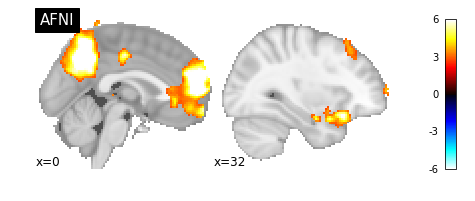

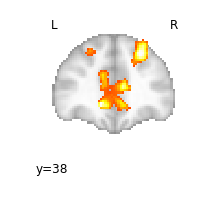

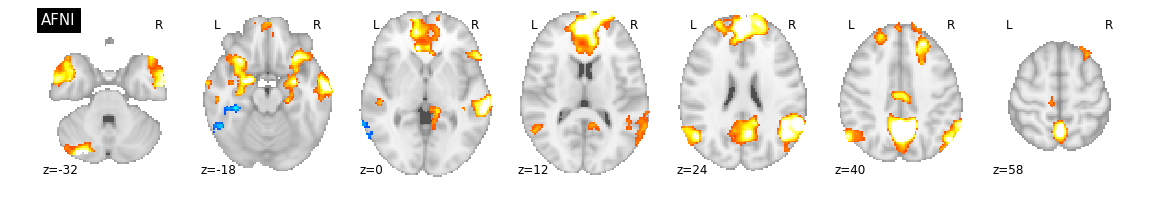

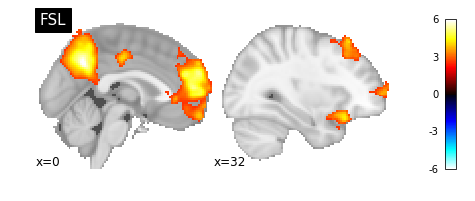

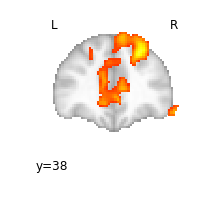

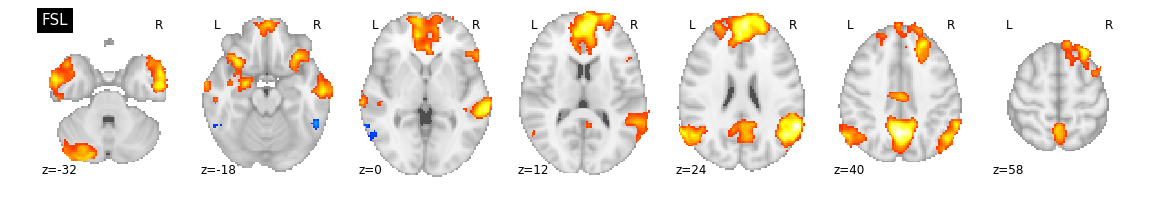

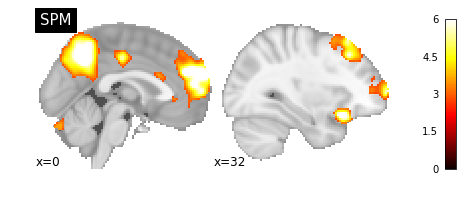

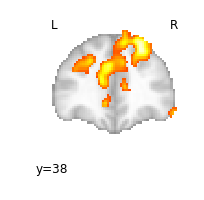

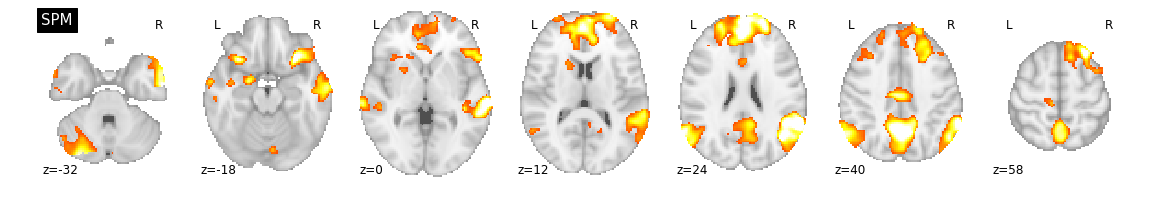

In [6]:
from lib import plot_excursion_sets
# Determine the scale of the activation colorbar
max_activation=6
# Determine the coordinates of the x, y, and z axial slices to be displayed
x_coords=[0, 32]
y_coords=[38]
z_coords=[-32, -18, 0, 12, 24, 40, 58]

plot_excursion_sets.plot_excursion_sets(exc_sets, max_activation, x_coords, y_coords, z_coords)

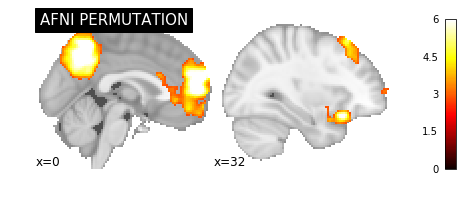

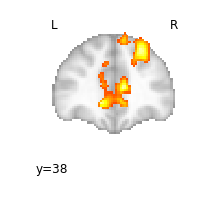

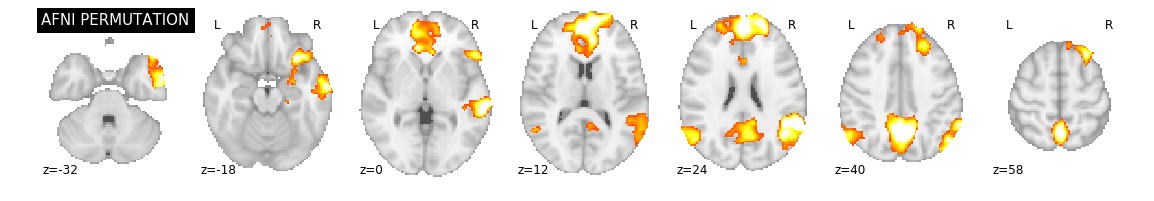

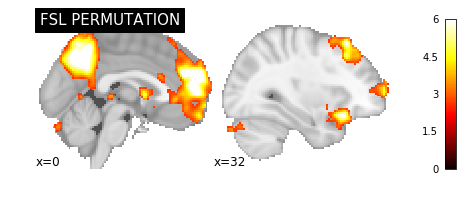

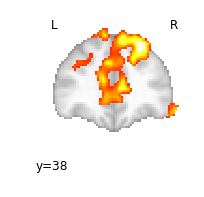

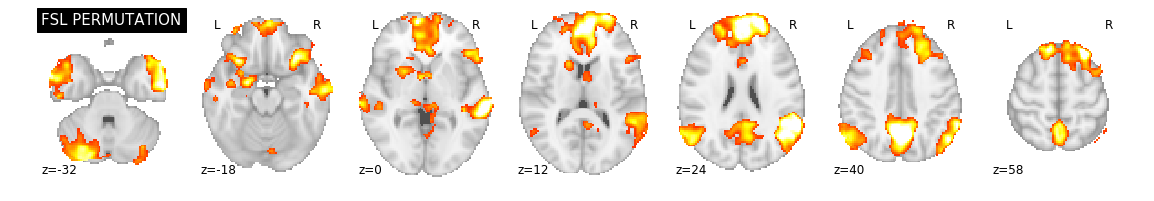

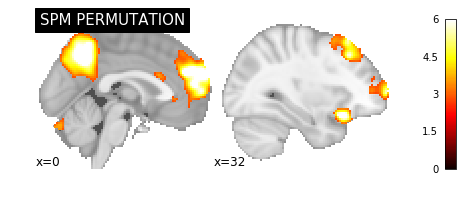

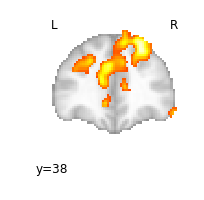

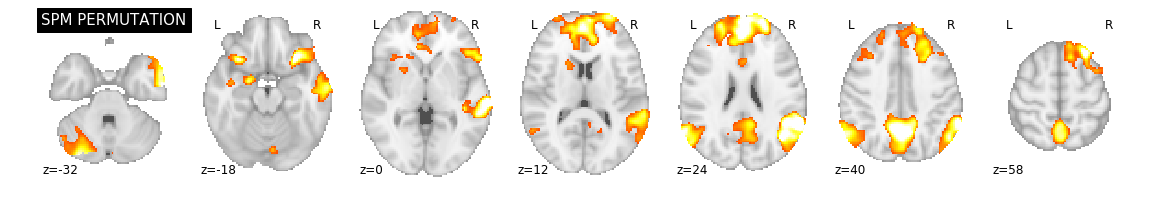

In [7]:
# Plot t-statistic images for permutation test inference results in each software
plot_excursion_sets.plot_excursion_sets(perm_exc_sets, max_activation, x_coords, y_coords, z_coords)

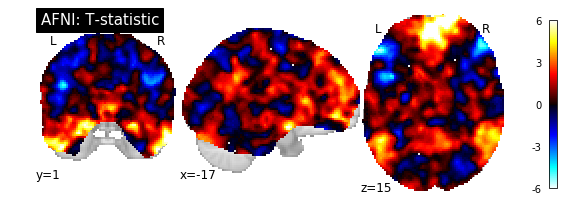

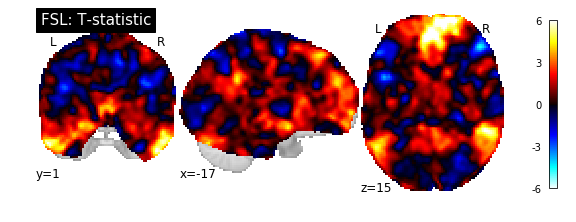

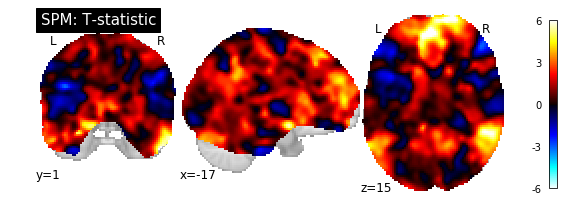

In [8]:
from lib import plot_stat_images
plot_stat_images.plot_stat_images(afni_stat_file, spm_stat_file, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_file)

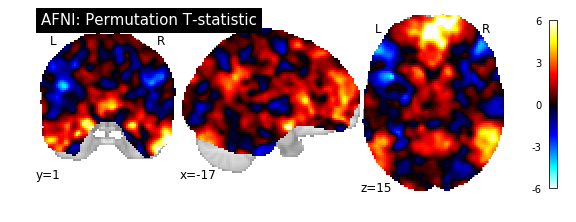

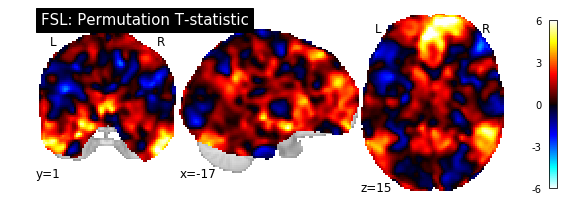

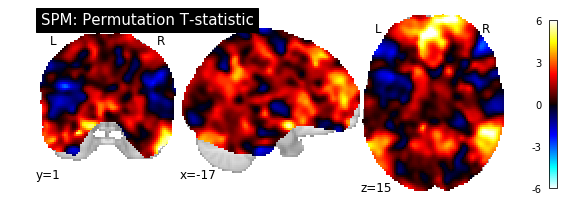

In [9]:
plot_stat_images.plot_stat_images(afni_perm, spm_perm, max_activation, [-17, 1, 15], 'Permutation T-statistic', fsl_perm)

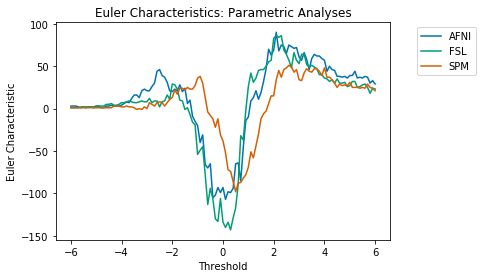

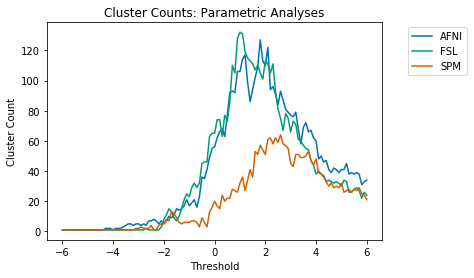

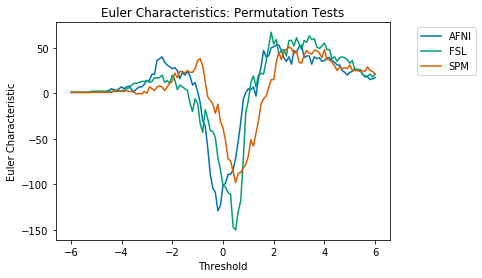

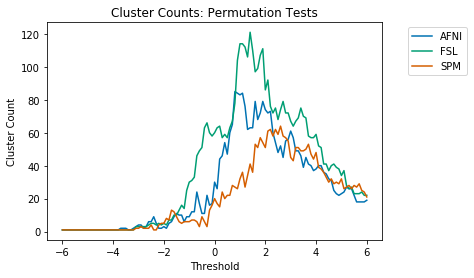

In [10]:
from lib import euler_characteristics
reload(euler_characteristics)
euler_characteristics.euler_characteristics(euler_chars, 'Parametric Analyses')
euler_characteristics.euler_characteristics(perm_euler_chars, 'Permutation Tests')

pixdim[1,2,3] should be positive; setting to abs of pixdim values
pixdim[1,2,3] should be positive; setting to abs of pixdim values
lib/bland_altman.py:98: RuntimeWarning: invalid value encountered in greater_equal
  white_matter_mask = white_matter >= 0.5
lib/bland_altman.py:100: RuntimeWarning: invalid value encountered in greater_equal
  csf_mask = csf >= 0.5


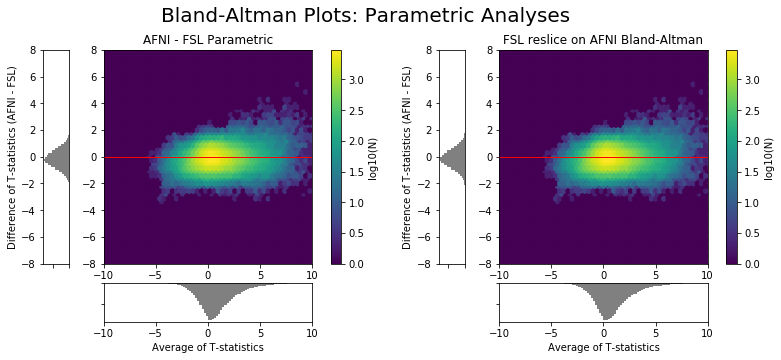

Mean =  -0.138203 , Standard Devation =  0.701078 , Correlation Coefficient =  0.933292


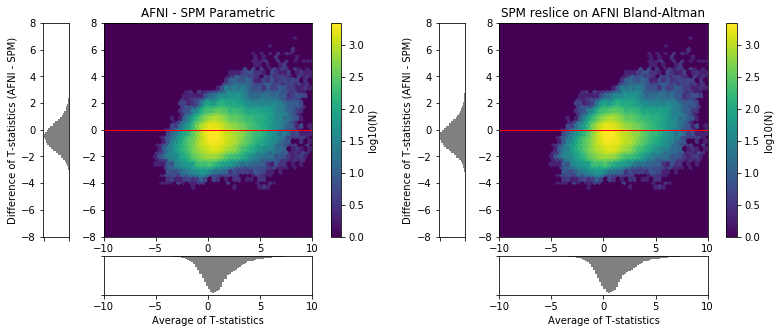

Mean =  -0.456019 , Standard Devation =  1.05214 , Correlation Coefficient =  0.841693


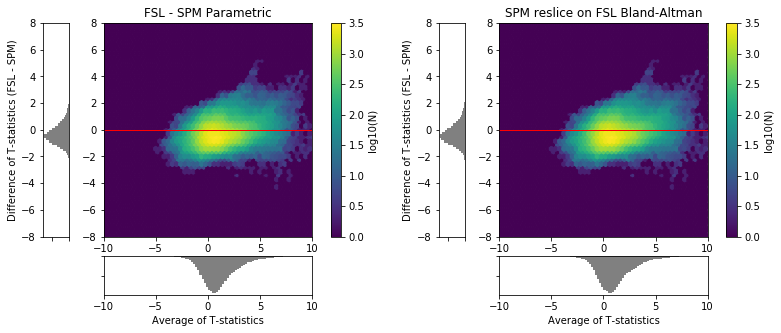

Mean =  -0.317957 , Standard Devation =  0.773559 , Correlation Coefficient =  0.910181


In [11]:
from lib import bland_altman
bland_altman.bland_altman('Bland-Altman Plots: Parametric Analyses', afni_stat_file, spm_stat_file,
            'AFNI - SPM Parametric', 'AFNI - FSL Parametric', 'FSL - SPM Parametric',
             fsl_stat_file, study=study)

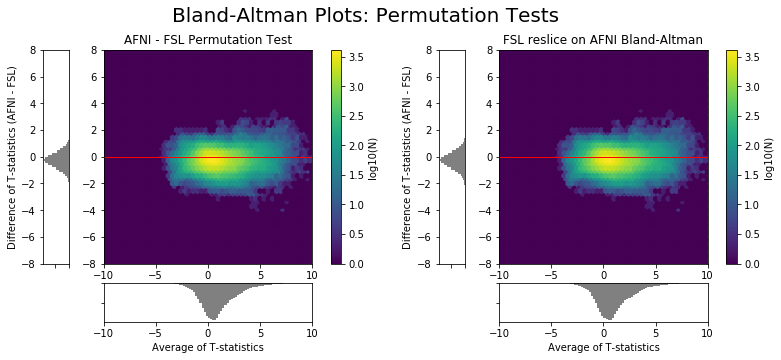

Mean =  -0.267099 , Standard Devation =  0.620786 , Correlation Coefficient =  0.93952


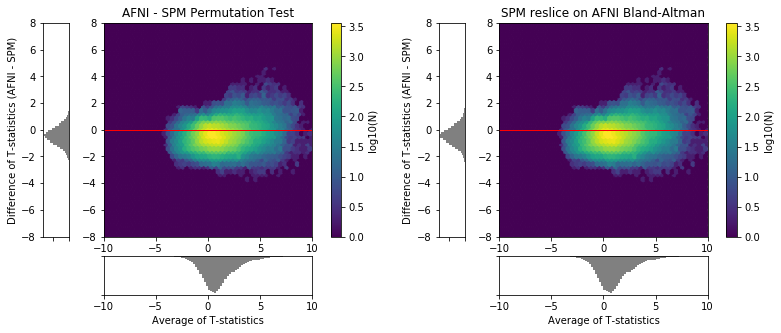

Mean =  -0.425314824237 , Standard Devation =  0.711632153519 , Correlation Coefficient =  0.917404840234


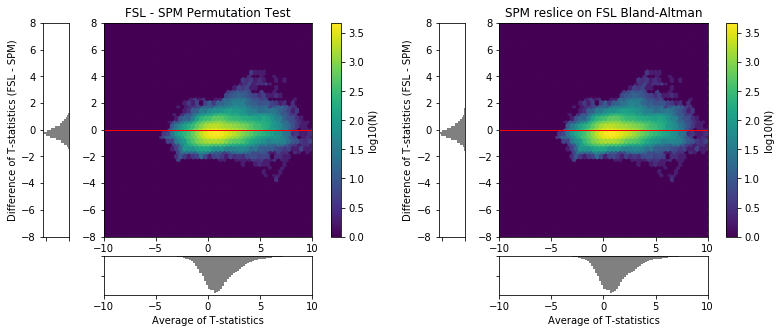

Mean =  -0.15822578855 , Standard Devation =  0.550788394859 , Correlation Coefficient =  0.951233546433


In [12]:
bland_altman.bland_altman('Bland-Altman Plots: Permutation Tests', afni_perm_z, spm_perm,
            'AFNI - SPM Permutation Test', 'AFNI - FSL Permutation Test', 'FSL - SPM Permutation Test',
             fsl_perm, num_subjects=num_subjects, study=study + '_perm')

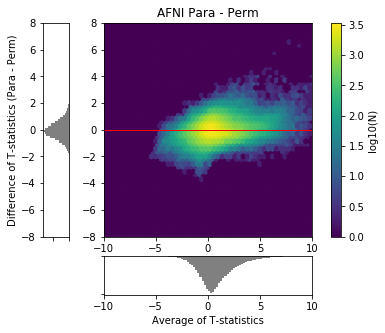

Mean =  -0.0308044 , Standard Devation =  0.707518 , Correlation Coefficient =  0.93177


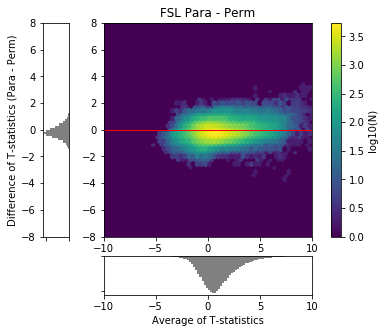

Mean =  -0.154013 , Standard Devation =  0.508651 , Correlation Coefficient =  0.960014


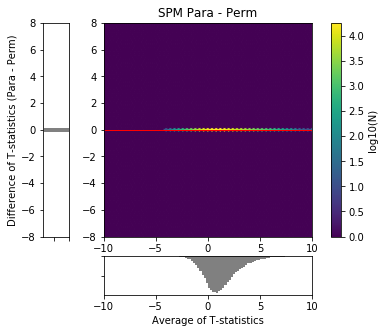

Mean =  -4.50430160702e-10 , Standard Devation =  7.70084917664e-08 , Correlation Coefficient =  1.0


In [13]:
bland_altman.bland_altman_intra('Bland-Altman Plots: Parametric vs Permutation', afni_stat_file, afni_perm_z,
             fsl_stat_file, fsl_perm,
             spm_stat_file, spm_perm,
             num_subjects=num_subjects, study=study + '_permintra')

pixdim[1,2,3] should be positive; setting to abs of pixdim values
pixdim[1,2,3] should be positive; setting to abs of pixdim values


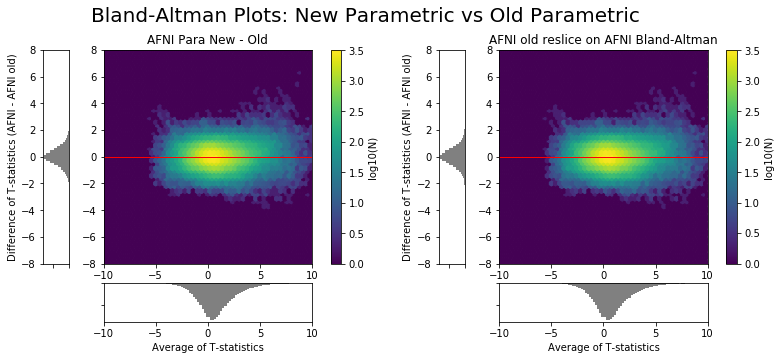

Mean =  0.00485234 , Standard Devation =  0.706069 , Correlation Coefficient =  0.933541


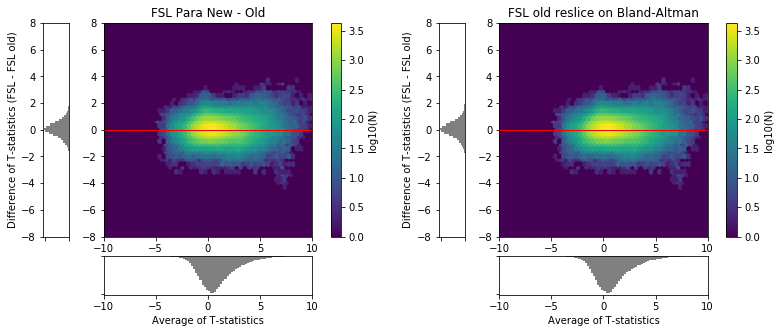

Mean =  0.0476112 , Standard Devation =  0.645048 , Correlation Coefficient =  0.937878


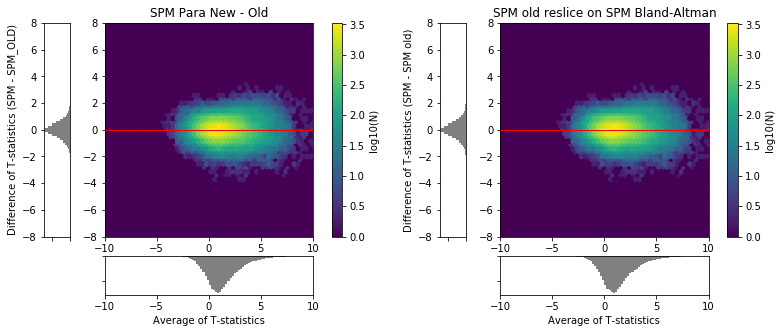

Mean =  -0.00190976 , Standard Devation =  0.639632 , Correlation Coefficient =  0.927499


In [14]:
reload(bland_altman)
bland_altman.bland_altman_old_comparison("Bland-Altman Plots: New Parametric vs Old Parametric", afni_stat_file, spm_stat_file,
                            old_afni_stat_file, old_spm_stat_file, "AFNI Para New - Old", "FSL Para New - Old",
                            "SPM Para New - Old", fsl_stat_file, old_fsl_stat_file, study=study)

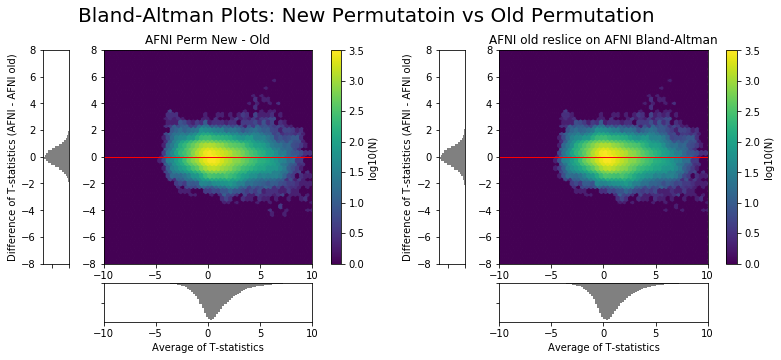

Mean =  -0.0175439 , Standard Devation =  0.708435 , Correlation Coefficient =  0.925077


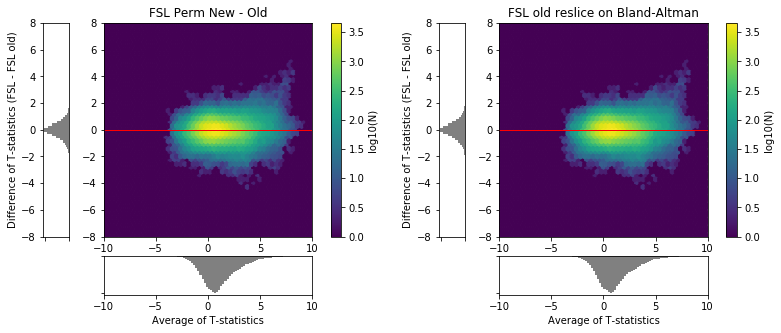

Mean =  -0.0318802 , Standard Devation =  0.638465 , Correlation Coefficient =  0.933092


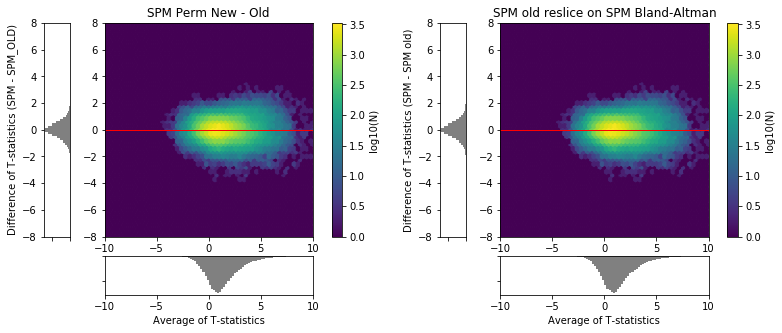

Mean =  -0.00190976504608 , Standard Devation =  0.63963204198 , Correlation Coefficient =  0.927498432262


In [15]:
bland_altman.bland_altman_old_comparison("Bland-Altman Plots: New Permutatoin vs Old Permutation", afni_perm_z, spm_perm,
                            old_afni_perm_z, old_spm_perm, "AFNI Perm New - Old", "FSL Perm New - Old",
                            "SPM Perm New - Old", fsl_perm, old_fsl_perm, num_subjects=num_subjects, study=study + '_perm')

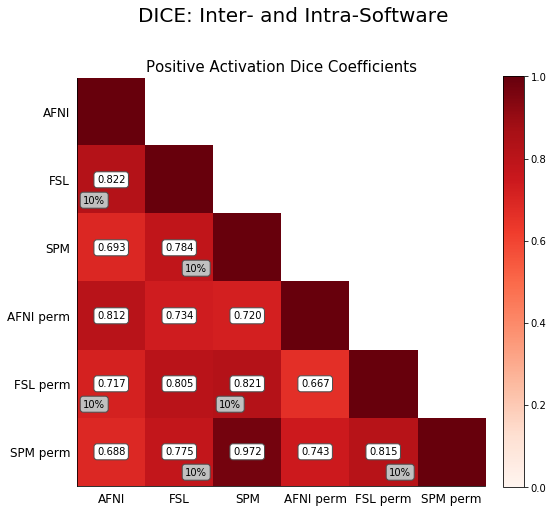

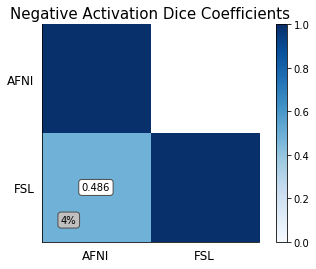

In [16]:
from lib import dice
reload(dice)
dice.dice(afni_exc_set_file, spm_exc_set_file, 
         afni_perm_pos_exc, spm_perm_pos_exc,
         afni_exc_set_file_neg, spm_exc_set_file_neg,
         fsl_exc_set_file, fsl_exc_set_file_neg, 
         fsl_perm_pos_exc, study=study,
         afni_stat_file=afni_stat_file, fsl_stat_file=fsl_stat_file, spm_stat_file=spm_stat_file,
         afni_perm=afni_perm, fsl_perm=fsl_perm, spm_perm=spm_perm,
         )

lib/dice.py:107: UserWarning: Resliced 1/2 and 2/1 dark dices 1 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")
lib/dice.py:110: UserWarning: Resliced 1/2 and 2/1 dark dices 2 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 2 are not close")
lib/dice.py:104: UserWarning: Resliced 1/2 and 2/1 dices are not close
  warnings.warn("Resliced 1/2 and 2/1 dices are not close")


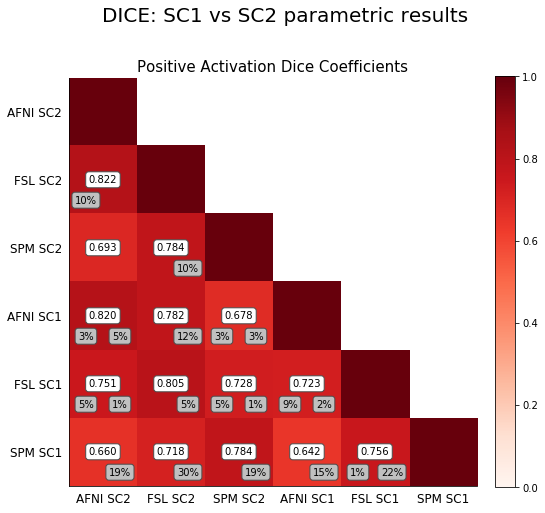

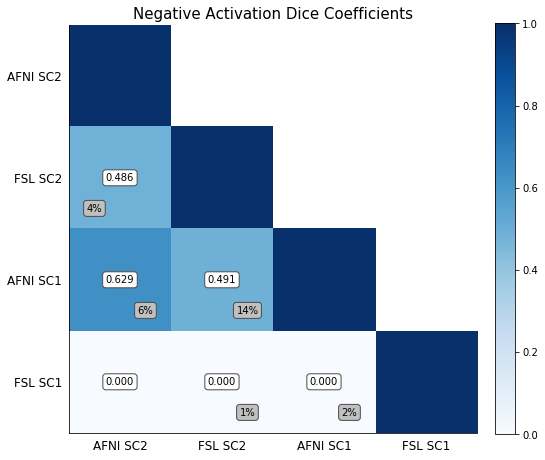

In [17]:
dice.dice_old_comparison(afni_exc_set_file, old_afni_exc_set_file, afni_exc_set_file_neg, old_afni_exc_set_file_neg,
                        fsl_exc_set_file, old_fsl_exc_set_file, fsl_exc_set_file_neg, old_fsl_exc_set_file_neg, 
                        spm_exc_set_file, old_spm_exc_set_file, afni_stat_file=afni_stat_file, old_afni_stat_file=old_afni_stat_file,
                        fsl_stat_file=fsl_stat_file, old_fsl_stat_file=old_fsl_stat_file, spm_stat_file=spm_stat_file, old_spm_stat_file=old_spm_stat_file, study=study, ds109_flag=True)

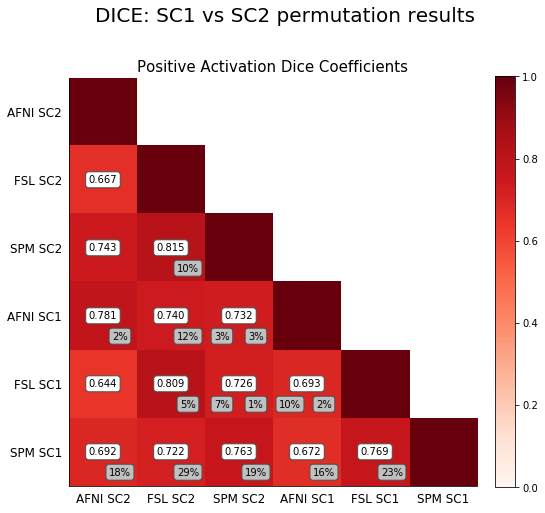

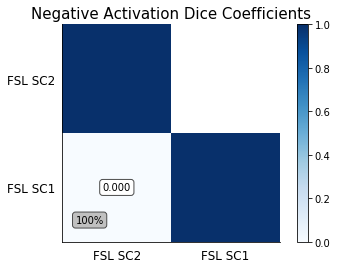

In [18]:
reload(dice)
dice.dice_old_comparison(afni_perm_pos_exc, old_afni_perm_pos_exc,
                        fsl_pos_exc=fsl_perm_pos_exc, old_fsl_pos_exc=old_fsl_perm_pos_exc, fsl_neg_exc=None, old_fsl_neg_exc=old_fsl_perm_neg_exc, 
                        spm_pos_exc=spm_perm_pos_exc, old_spm_pos_exc=old_spm_perm_pos_exc, afni_stat_file=afni_perm, old_afni_stat_file=old_afni_perm_z,
                        fsl_stat_file=fsl_perm, old_fsl_stat_file=old_fsl_perm, spm_stat_file=spm_perm, old_spm_stat_file=old_spm_perm, study=study + '_perm', perm=True, ds109_flag=True)

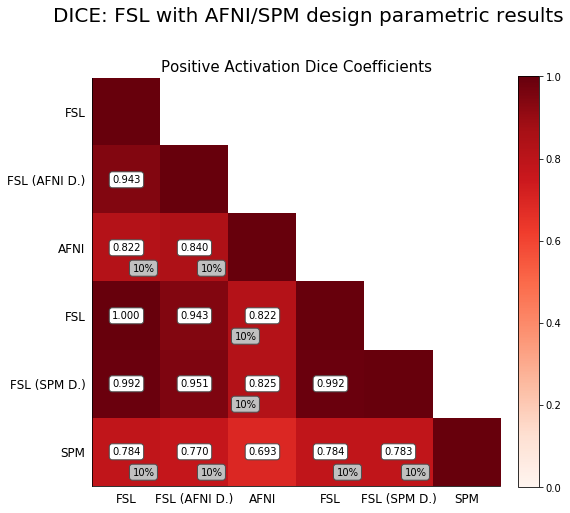

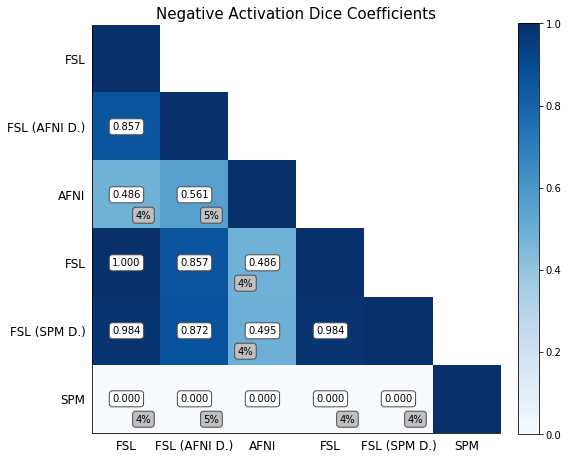

In [19]:
dice.dice_old_comparison(fsl_exc_set_file, fsl_exc_set_file, fsl_exc_set_file_neg, fsl_exc_set_file_neg,
                        afni_design_exc_set_file, spm_design_exc_set_file, afni_design_exc_set_file_neg, spm_design_exc_set_file_neg, 
                        afni_exc_set_file, spm_exc_set_file, afni_exc_set_file_neg, spm_exc_set_file_neg, 
                        fsl_stat_file, fsl_stat_file, afni_design_stat_file, spm_design_stat_file, afni_stat_file, 
                        spm_stat_file, study=study, design=True)

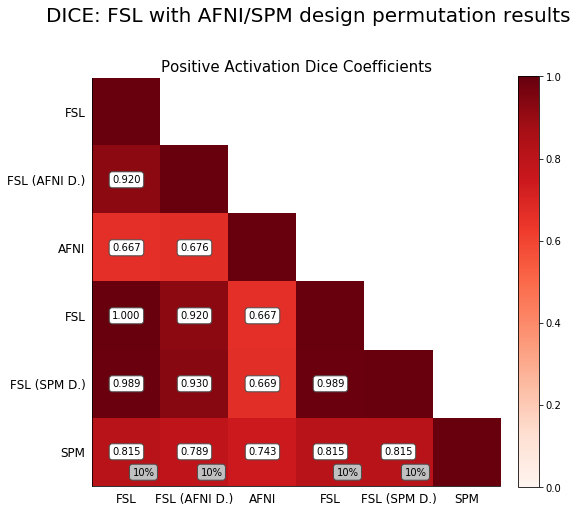

In [20]:
reload(dice)
dice.dice_old_comparison(fsl_perm_pos_exc, fsl_perm_pos_exc, None, None, 
                         afni_design_perm_pos_exc,  spm_design_perm_pos_exc, None, None, 
                         afni_perm_pos_exc,  spm_perm_pos_exc, None, None,
                         fsl_perm, fsl_perm, afni_design_perm, spm_design_perm, afni_perm, spm_perm, study=study + '_perm', perm=True, design=True, ds109_flag=True)

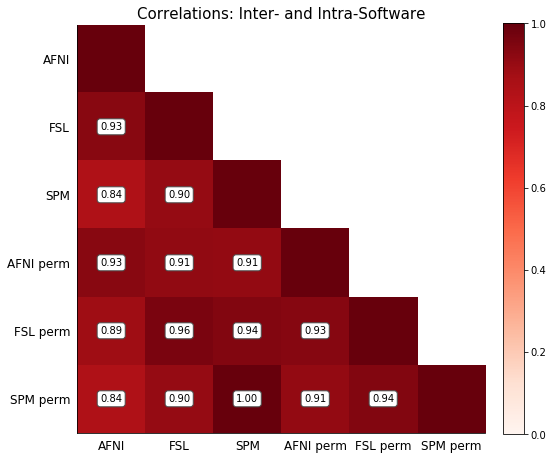

In [21]:
from lib import correlation_tables
correlation_tables.correlation_tables(afni_stat_file, fsl_stat_file, spm_stat_file, afni_perm_z, fsl_perm, spm_perm, title="Correlations: Inter- and Intra-Software", num_subjects=21)

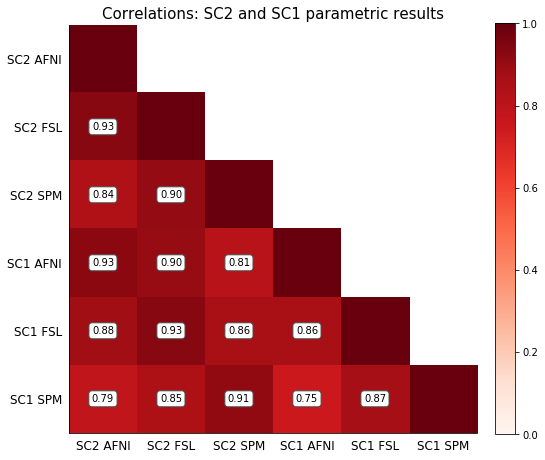

In [22]:
correlation_tables.correlation_tables(afni_stat_file, fsl_stat_file, spm_stat_file, old_afni_stat_file, old_fsl_stat_file, old_spm_stat_file, title="Correlations: SC2 and SC1 parametric results")

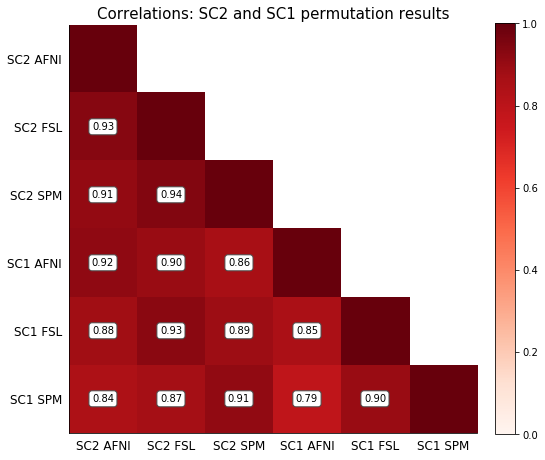

In [23]:
correlation_tables.correlation_tables(afni_perm_z, fsl_perm, spm_perm, old_afni_perm_z, old_fsl_perm, old_spm_perm, title="Correlations: SC2 and SC1 permutation results", num_subjects=21)

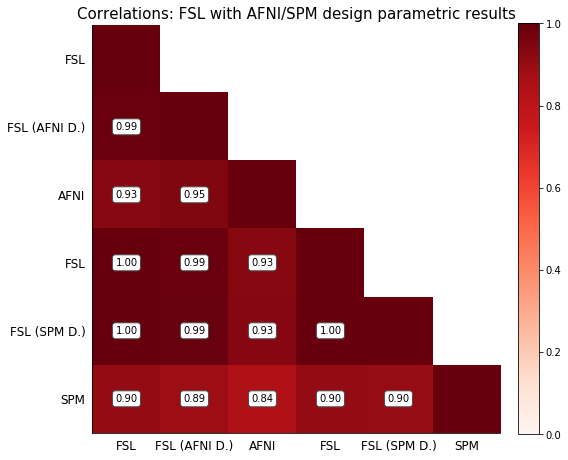

In [24]:
correlation_tables.correlation_tables(fsl_stat_file, afni_design_stat_file, afni_stat_file, fsl_stat_file, spm_design_stat_file, spm_stat_file, title="Correlations: FSL with AFNI/SPM design parametric results")

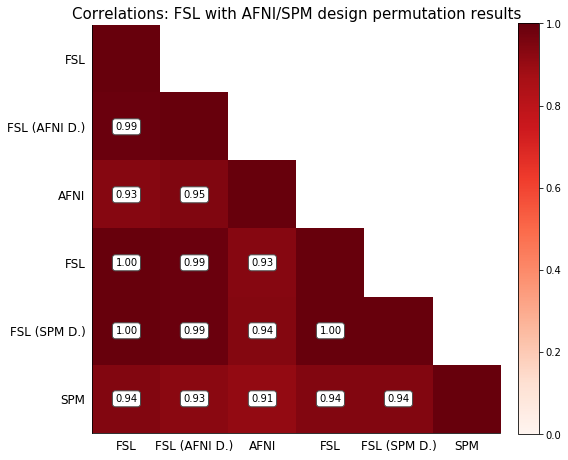

In [25]:
correlation_tables.correlation_tables(fsl_perm, afni_design_perm, afni_perm_z, fsl_perm, spm_design_perm, spm_perm, title="Correlations: FSL with AFNI/SPM design permutation results", num_subjects=21)

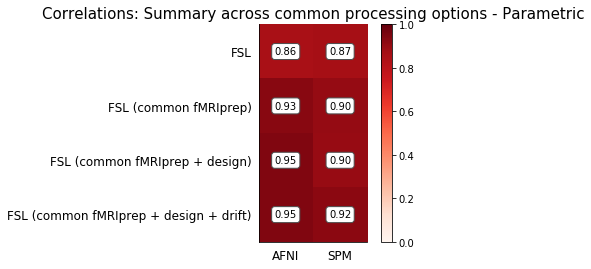

In [26]:
reload(correlation_tables)
correlation_tables.correlation_summary_across_processing_opts(old_afni_stat_file, old_fsl_stat_file, old_spm_stat_file, afni_stat_file, fsl_stat_file, spm_stat_file, afni_design_stat_file, spm_design_stat_file, afni_drift_stat_file, spm_drift_stat_file, title="Correlations: Summary across common processing options - Parametric")

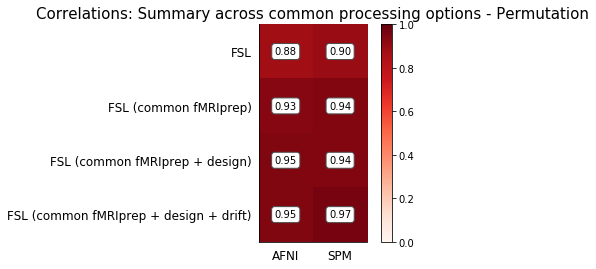

In [27]:
correlation_tables.correlation_summary_across_processing_opts(old_afni_perm_z, old_fsl_perm, old_spm_perm, afni_perm_z, fsl_perm, spm_perm, afni_design_perm, spm_design_perm, afni_drift_perm, spm_drift_perm, title="Correlations: Summary across common processing options - Permutation", num_subjects=21)

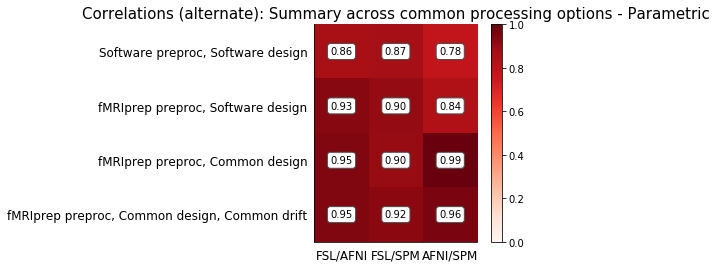

In [28]:
correlation_tables.correlation_summary_across_processing_opts_alternate(old_afni_stat_file, old_fsl_stat_file, old_spm_stat_file, afni_stat_file, fsl_stat_file, spm_stat_file, afni_design_stat_file, spm_design_stat_file, afni_drift_stat_file, spm_drift_stat_file, title="Correlations (alternate): Summary across common processing options - Parametric")

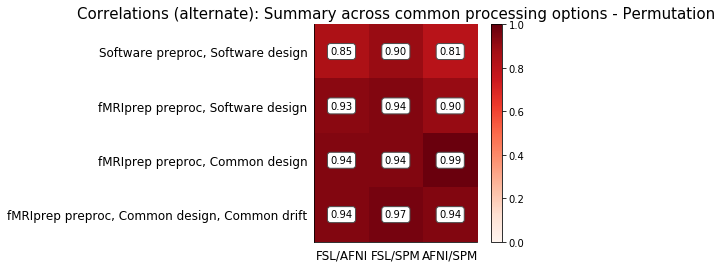

In [29]:
correlation_tables.correlation_summary_across_processing_opts_alternate(old_afni_perm_z, old_fsl_perm, old_spm_perm, afni_perm_z, fsl_perm, spm_perm, afni_design_perm, spm_design_perm, afni_drift_perm, spm_drift_perm, title="Correlations (alternate): Summary across common processing options - Permutation", num_subjects=21)

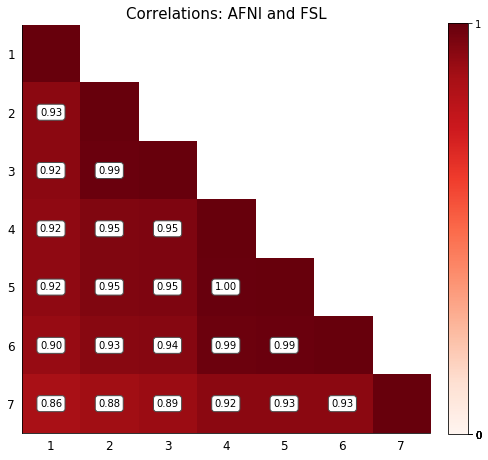

In [30]:
from lib import correlation_tables
reload(correlation_tables)
correlation_tables.new_correlation_tables(old_afni_stat_file, afni_stat_file, fsl_afni_subject_level_stat_file, afni_drift_stat_file, afni_design_stat_file, fsl_stat_file, old_fsl_stat_file, title= "Correlations: AFNI and FSL")

lib/new_dice.py:114: UserWarning: Resliced 1/2 and 2/1 dark dices 1 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")
lib/new_dice.py:117: UserWarning: Resliced 1/2 and 2/1 dark dices 2 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 2 are not close")


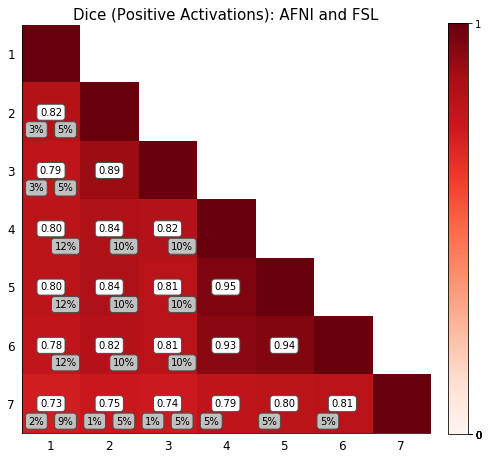

In [31]:
from lib import new_dice
new_dice.new_dice(old_afni_exc_set_file, afni_exc_set_file, fsl_afni_subject_level_exc_set_file, afni_drift_exc_set_file, afni_design_exc_set_file, fsl_exc_set_file, old_fsl_exc_set_file,
                  old_afni_stat_file, afni_stat_file, fsl_afni_subject_level_stat_file, afni_drift_stat_file, afni_design_stat_file, fsl_stat_file, old_fsl_stat_file,
                 Title='Dice (Positive Activations): AFNI and FSL')

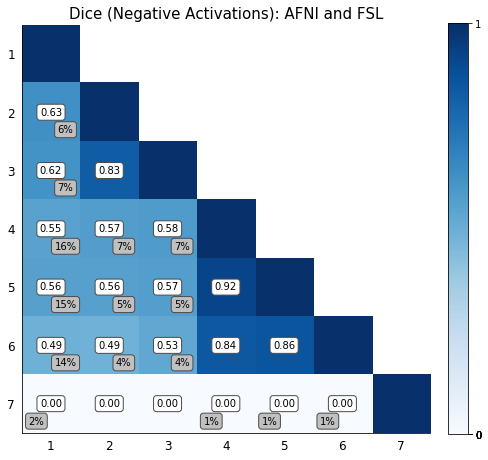

In [32]:
new_dice.new_dice(old_afni_exc_set_file_neg, afni_exc_set_file_neg, fsl_afni_subject_level_exc_set_file_neg, afni_drift_exc_set_file_neg, afni_design_exc_set_file_neg, fsl_exc_set_file_neg, old_fsl_exc_set_file_neg,
                  old_afni_stat_file, afni_stat_file, fsl_afni_subject_level_stat_file, afni_drift_stat_file, afni_design_stat_file, fsl_stat_file, old_fsl_stat_file,
                  Positive=False, Title='Dice (Negative Activations): AFNI and FSL')

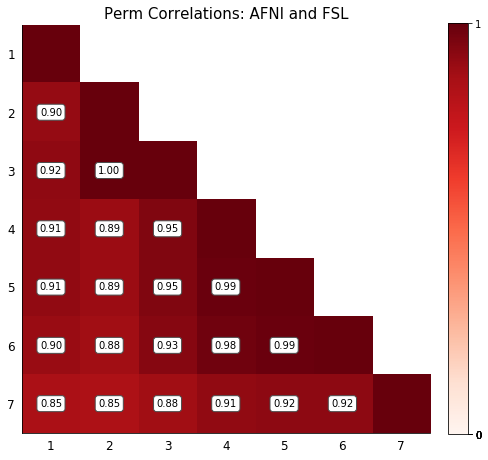

In [33]:
correlation_tables.new_correlation_tables(old_afni_perm_z, afni_perm, fsl_afni_subject_level_perm, afni_drift_perm, afni_design_perm, fsl_perm, old_fsl_perm, "Perm Correlations: AFNI and FSL", 21)

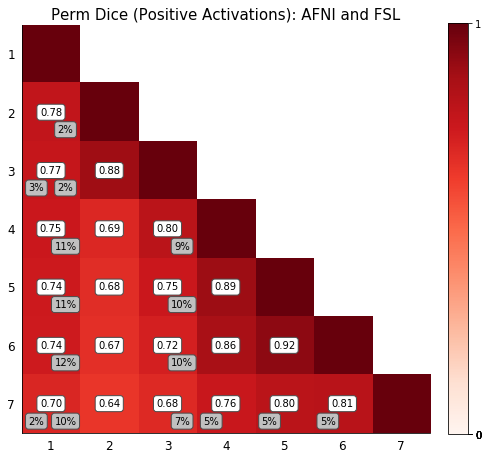

In [34]:
new_dice.new_dice(old_afni_perm_pos_exc, afni_perm_pos_exc, fsl_afni_subject_level_perm_pos_exc, afni_drift_perm_pos_exc, afni_design_perm_pos_exc, fsl_perm_pos_exc, old_fsl_perm_pos_exc,
                  old_afni_perm_z, afni_perm, fsl_afni_subject_level_perm, afni_drift_perm, afni_design_perm, fsl_perm, old_fsl_perm,
                 Title='Perm Dice (Positive Activations): AFNI and FSL')

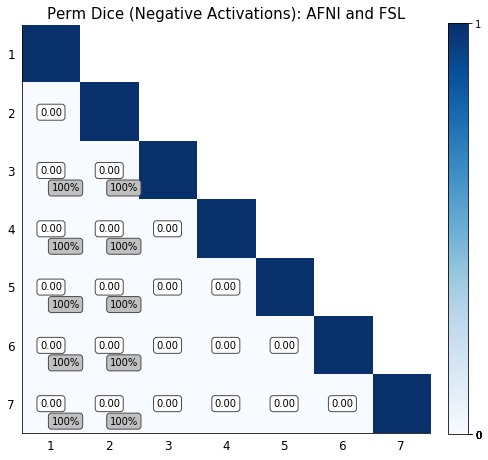

In [35]:
new_dice.new_dice(None, None, fsl_afni_subject_level_perm_neg_exc, afni_drift_perm_neg_exc, afni_design_perm_neg_exc, fsl_perm_neg_exc, old_fsl_perm_neg_exc,
                  old_afni_perm_z, afni_perm, fsl_afni_subject_level_perm, afni_drift_perm, afni_design_perm, fsl_perm, old_fsl_perm,
                  Positive=False, Title='Perm Dice (Negative Activations): AFNI and FSL')

In [36]:
correlation_tables.z_to_t(old_afni_perm_pos_exc, old_afni_perm_pos_exc.replace('.nii.gz', '_t.nii.gz'), 21)

'./input/ds109/old_afni_perm_exc_set_pos_t.nii.gz'

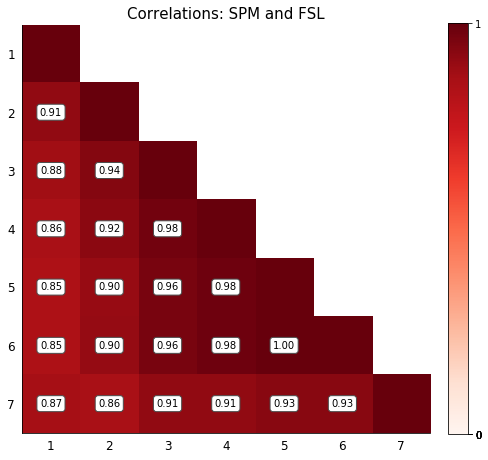

In [37]:
correlation_tables.new_correlation_tables(old_spm_stat_file, spm_stat_file, fsl_spm_subject_level_stat_file, spm_drift_stat_file, spm_design_stat_file, fsl_stat_file, old_fsl_stat_file, title= "Correlations: SPM and FSL")

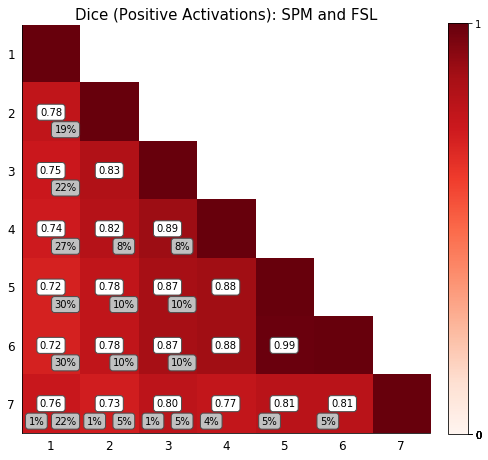

In [38]:
new_dice.new_dice(old_spm_exc_set_file, spm_exc_set_file, fsl_spm_subject_level_exc_set_file, spm_drift_exc_set_file, spm_design_exc_set_file, fsl_exc_set_file, old_fsl_exc_set_file,
                  old_spm_stat_file, spm_stat_file, fsl_spm_subject_level_stat_file, spm_drift_stat_file, spm_design_stat_file, fsl_stat_file, old_fsl_stat_file,
                 Title='Dice (Positive Activations): SPM and FSL')

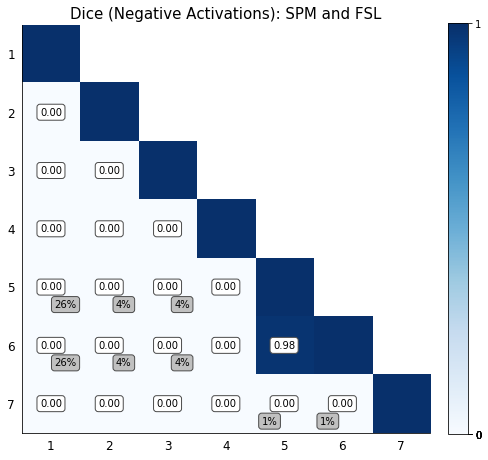

In [39]:
reload(new_dice)
new_dice.new_dice(old_spm_exc_set_file_neg, spm_exc_set_file_neg, fsl_spm_subject_level_exc_set_file_neg, spm_drift_exc_set_file_neg, spm_design_exc_set_file_neg, fsl_exc_set_file_neg, old_fsl_exc_set_file_neg,
                  old_spm_stat_file, spm_stat_file, fsl_spm_subject_level_stat_file, spm_drift_stat_file, spm_design_stat_file, fsl_stat_file, old_fsl_stat_file,
                  Positive=False, Title='Dice (Negative Activations): SPM and FSL')

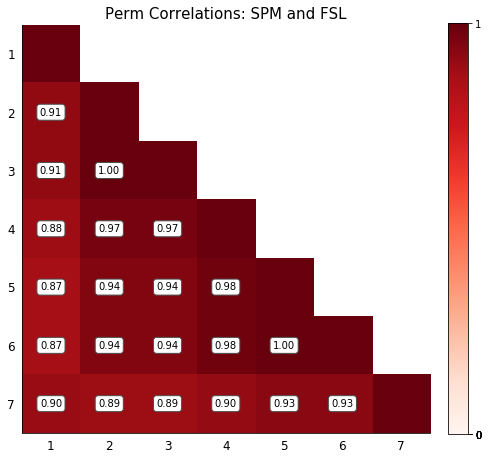

In [40]:
reload(correlation_tables)
correlation_tables.new_correlation_tables(old_spm_perm, spm_perm, fsl_spm_subject_level_perm, spm_drift_perm, spm_design_perm, fsl_perm, old_fsl_perm, title= "Perm Correlations: SPM and FSL")

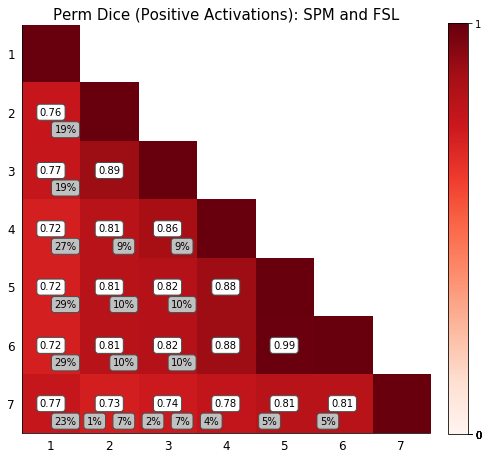

In [41]:
new_dice.new_dice(old_spm_perm_pos_exc, spm_perm_pos_exc, fsl_spm_subject_level_perm_pos_exc, spm_drift_perm_pos_exc, spm_design_perm_pos_exc, fsl_perm_pos_exc, old_fsl_perm_pos_exc,
                  old_spm_perm, spm_perm, fsl_spm_subject_level_perm, spm_drift_perm, spm_design_perm, fsl_perm, old_fsl_perm,
                 Title='Perm Dice (Positive Activations): SPM and FSL')

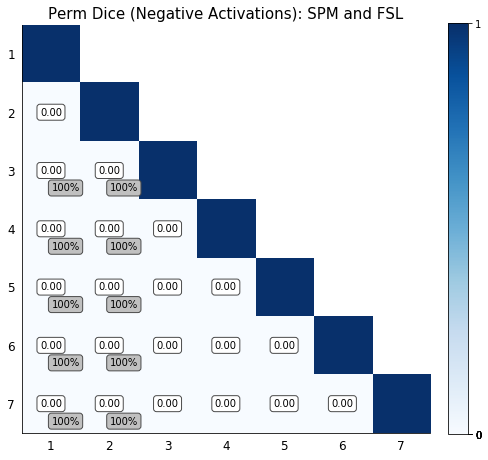

In [42]:
reload(new_dice)
new_dice.new_dice(None, None, fsl_spm_subject_level_perm_neg_exc, spm_drift_perm_neg_exc, spm_design_perm_neg_exc, fsl_perm_neg_exc, old_fsl_perm_neg_exc,
                  old_spm_perm, spm_perm, fsl_spm_subject_level_perm, spm_drift_perm, spm_design_perm, fsl_perm, old_fsl_perm,
                  Positive=False, Title='Perm Dice (Negative Activations): SPM and FSL')